# Simulador de Ejes
### Ian Gross Sánchez

## Librerías

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid as cumtrapz

## Moments of Inertia

In [ ]:
cross = 'solid_rectangular'
b = float(0.1) # Rectangular base [m]
h = float(0.2) # Rectangular height [m]
A = b * h  # Cross-sectional area [m^2]
Vol = A
C = 1.5  # Shear correction factor for rectangular section
I = b * h**3 / 12  # Moment of inertia [m^4]
y_max = h / 2  # Maximum distance from the neutral axis to the outer fiber [m]

# cross = 'solid_circular'
# D = float(0.5) # Circular diameter [m]
# r = D / 2  # Circular radius [m]
# C = 1.33  # Shear correction factor for circular section
# I = np.pi * r**4 / 4  # Moment of inertia [m^4]
# J = np.pi * r**4 / 2  # Polar moment of inertia [m^4]
# A = np.pi * r**2  # Cross-sectional area [m^2]
# y_max = r  # Maximum distance from the neutral axis to the outer fiber [m]

# cross = 'hollow_circular'
# D = float(0.5) # Circular diameter [m]
# re = D / 2  # Circular outer radius [m]
# d = float(0.2) # Circular inner diameter [m]
# ri = d / 2  # Circular inner radius [m]
# C = 2  # Shear correction factor for circular section
# I = np.pi * (re**4 - ri**4) / 4  # Moment of inertia [m^4]
# J = np.pi * re**4 - ri**4) / 2  # Polar moment of inertia [m^4]
# A = np.pi * re**2  # Cross-sectional area [m^2]
# y_max = re  # Maximum distance from the neutral axis to the outer fiber [m]

## Material Properties

In [ ]:
#####################
# Material properties
#####################
name = 'AISI4140'
type = 'steel'

#######################
# Mechanical properties
#######################
rho = 7850  # Density [kg/m^3]
sigma_tension = 1770  # Yield strength [MPa]

E = 210*10**9           # Young's modulus [Pa]
nu = 0.3                # Poisson's ratio
G = E / (2 * (1 + nu))  # Shear modulus [Pa]

print('E =', E)
print('G =', G)

## Geometry

In [ ]:
##########
# Geometry
##########
# Coordinate system
# y ^
#   |
# z o---> x
g = 9.81 #-ŷ  # Gravity [m/s^2]

# Beam
L = 1.0   # Length [m]
x = np.linspace(0, L, 1000)
Vol = A * L # Volume [m^3]
m = rho * Vol  # Mass [kg]

## Support

In [ ]:
# Voladizo
# Cantilever Beam
# |-----------
# support = 'fixed-free'


# Viga simplemente apoyada
# Simply Supported Beam
# ------------
# ^         oo
support = 'supported-supported'


# Viga biempotrada
# Fixed-Fixed Beam
# |-----------|
# support = 'fixed-fixed'


# Viga empotrada-articulada
# Fixed-Supported Beam
# |------------
#            oo
# support = 'fixed-supported'


# Viga con voladizo
# Overhanging Beam
# ------------
# ^      oo
# support = 'overhanging'
# supports = [0, 1]  # Support points for overhanging beam

## Free Body Diagram

In [ ]:
########
# Forces
########
# Gravity Load
xFg_bar = L / 2 # x coordinate center of gravity
XFg_load = np.array([0.00,])  # x coordinate of gravity load application point

######
# Beam
######
positions = [
    (0.00, 'Apoyo Simple'), # 1
    (0.02, 'Engrane Recto'), # 2
    (0.02 + 0.07, 'Engrane Epicíclico'), # 3
    (0.02 + 0.07 + 0.07, 'Engrane Epicíclico'), # 4
    (0.02 + 0.07 + 0.07 + 0.07, 'Apoyo Simple') # 5
]

Fg_bar = rho * Vol * g  # Gravity Load [N/m]
# Point Loads
xF = np.array([L/4, 0])     # x coordinate of applied force
F = np.array([-100, 0])*1e3  # Perpendicular Forces [kN]

# Distributed Loads
xIq = np.array([0, 0])     # x coordinate of distributed load start
xFq = np.array([0, 0])       # x coordinate of distributed load end
q = np.array([0, 0])*1e3  # Constant Distributed Load along the Beam [kN/m]


#########
# Moments
#########
# Bending Moments
xMBz = np.array([0, 0])  # x coordinate [m] - TopBottom Bending Moment
MBz = np.array([0, 0])  # TopBottom Bending Moment [N*m]

# Torsional Moments
xMTx = np.array([0, 0])  # x coordinate [m] - Torsional Moment
MTx = np.array([0, 0]) # Torsional Moment [N*m]

## Distribución de Cargas

In [ ]:
#########
# Weights
#########
# Cilindro Sólido
def gear_weight(d_mm, e_mm):
    r = d_mm / 2000  # Radio [m]
    e_m = e_mm / 1000 # Espesor [m]
    volume = np.pi * r**2 * e_m
    mass = rho * volume
    return mass * g 

e = 60      # Espesor de cara [mm]

# 0
D_E0 = 236  # Engrane Recto [mm]
# 1
D_ES1 = 72  # Engrane Epicíclico 1 - Sol [mm]
D_EP1 = 84  # Engrane Epicíclico 1 - Planeta [mm]
D_EC1 = 240  # Engrane Epicíclico 1 - Corona [mm]
# 2
D_ES2 = 168  # Engrane Epicíclico 2 - Sol [mm]
D_EP2 = 68  # Engrane Epicíclico 2 - Planeta [mm]
D_EC2 = 304  # Engrane Epicíclico 2 - Corona [mm]

# Pesos individuales
W_g0 = gear_weight(D_E0, e)  # Engrane Recto
W_g1 = gear_weight(D_EC1, e)  # Engrane Epicíclico pequeño
W_g2 = gear_weight(D_EC2, e)  # Engrane Epicíclico grande

# Asignar pesos a posiciones
weight_map = {
    1: W_g0,  # Engrane Recto
    2: W_g1,  # Engrane Epicíclico 1
    3: W_g2   # Engrane Epicíclico 2
}


r_CM0 = (D_E0 / 3) / 1000 # Radio del centroide [m] - 2/3 R = D/3
r_CM1 = (D_EC1/2)/1000 # Radio del centroide [m] - Corona
r_CM2 = (D_EC2/2) / 1000 # Radio del centroide [m] - Corona

radii_map = {
    1: r_CM0,  # Engrane Recto
    2: r_CM1,  # Engrane Epicíclico 1
    3: r_CM2   # Engrane Epicíclico 2
}

#################
# Informe
#################
print("El largo de la barra es:", round(L, 3), "m")
print("Elementos en la barra:")

for i, (p, msg) in enumerate(positions):
    line = f"{i+1}. {msg} en la posición {round(p * 1000, 2)} mm"
    if i in weight_map:
        w = weight_map[i]
        line += f" - Peso: {round(w, 2)} N"
        r = radii_map[i]
        line += f" - Radio del centroide: {round(r, 2)} m"

    print(line)

## Momento y Esfuerzos

In [313]:
#######################
# Stress contribution x
#######################

Mz = np.zeros_like(x, dtype=float) # Up-Down
# My = np.zeros_like(x, dtype=float) # Left-Right
# Mx = np.zeros_like(x, dtype=float) # Torsional


if support == 'fixed-free':
    for F_i, xF_i in zip(F, xF):
        Mz += F_i * (xF_i - x) * (x <= xF_i)
    for q_i, xIq_i, xFq_i in zip(q, xIq, xFq):
        Mz += np.where(x > xFq_i, 0, np.where(x < xIq_i, q_i/2 * (xFq_i - xIq_i) * (xIq_i + xFq_i - 2*x), q_i/2 * (xFq_i - x)**2))
    for MBz_i, xMBz_i in zip(MBz, xMBz):
        Mz += MBz_i * (x <= xMBz_i)  # TopBottom Bending Moment [N*m]

elif support == 'supported-supported':
    for F_i, xF_i in zip(F, xF):
        Mz += np.where(x < xF_i, F_i * (L - xF_i) * x / L, F_i * xF_i * (L - x) / L)
    for q_i, xIq_i, xFq_i in zip(q, xIq, xFq):
        pass


# sigmaz
sigmaz = Mz * y_max / I  # Bending stress [Pa]
sigma_max = np.max(np.abs(sigmaz))*1e-6  # Maximum bending stress [MPa]
print(f'Maximum bending stress: {sigma_max:.2f} MPa')


######################
# Shear contribution x
######################

V = np.zeros_like(x, dtype=float)
if support == 'fixed-free':
    for Fi, xi in zip(F, xF):
        V += Fi * (x <= xi)  # Shear force [N]
    for q_i, xIq_i, xFq_i in zip(q, xIq, xFq):
        V += np.where(x > xFq_i, 0, np.where(x < xIq_i, q_i * (xFq_i - xIq_i), q_i * (xFq_i - x)))

# tau
if cross == 'solid_rectangular':
    tauz = 3*V / (2*A)  # Shear stress [Pa]
elif cross == 'solid_circular':
    tauz = 4*V / (3*A)
elif cross == 'hollow_circular':
    tauz = 4*V / (3*A) * (re**2 + re*ri + ri**2) / (re**2 + ri**2)  # Shear stress [Pa]

tauz_max = np.max(np.abs(tauz))*1e-6  # Maximum shear stress [Pa]
print(f'Maximum shear stress: {tauz_max:.2f} MPa')


##################
# Von Mises stress
##################

von_mises = np.sqrt(sigmaz**2 + 3*tauz**2)  # Von Mises stress [Pa]
von_mises_max = np.max(von_mises) * 1e-6  # Maximum Von Mises stress [MPa]
print(f'Maximum Von Mises stress: {von_mises_max:.2f} MPa')

Maximum bending stress: 28.12 MPa
Maximum shear stress: 0.00 MPa
Maximum Von Mises stress: 28.12 MPa


##  Integración para Deflexión

In [314]:
if support == 'fixed-free':
    # Stress sigma
    theta = cumtrapz(Mz / (E*I), x, initial=0)
    delta_bending = cumtrapz(theta, x, initial=0)
    # Shear tau
    delta_shear = cumtrapz(C*V/(G*A), x, initial=0)

elif support == 'supported-supported':
    # Stress sigma
    theta0 = cumtrapz(Mz / (E*I), x, initial=0)
    delta0 = cumtrapz(theta0, x, initial=0)
    C2 = delta0[-1] / L
    theta = -theta0 + C2
    delta_bending = cumtrapz(theta, x, initial=0)
    # Shear tau
    delta_shear = cumtrapz(C*V/(G*A), x, initial=0)


# Total Deflection
delta_total = delta_bending + delta_shear

# Max Deflection
max_deflection_bending_mm = np.max(np.abs(delta_bending)) * 1e3
max_deflection_shear_mm = np.max(np.abs(delta_shear)) * 1e3
max_deflection_mm = np.max(np.abs(delta_total)) * 1e3
x_max = x[np.argmax(np.abs(delta_total))]

print(f'Maximum deflection due to bending: {max_deflection_bending_mm:.2f} mm')
print(f'Maximum deflection due to shear: {max_deflection_shear_mm:.2f} mm')
print(f'Maximum total deflection: {max_deflection_mm:.2f} mm')
print(f'Critical point: {x_max:.2f} m')

Maximum deflection due to bending: 0.10 mm
Maximum deflection due to shear: 0.00 mm
Maximum total deflection: 0.10 mm
Critical point: 0.44 m


## Plot

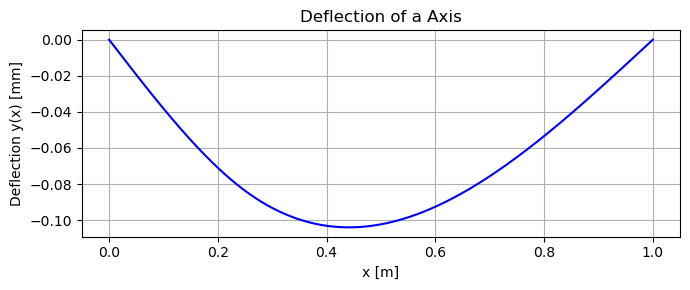

Support points = supported-supported
Cross-section: solid_rectangular, b: 0.1 m, h: 0.2 m, I: 6.67e-05 m^4, A: 2.00e-02 m^2
Max deflection at x = 0.441 m: 0.104 mm


In [315]:
plt.figure(figsize=(7, 3))
plt.plot(x, delta_bending * 1e3, color="blue")  # Convert to mm
plt.title("Deflection of a Axis")
plt.xlabel("x [m]")
plt.ylabel("Deflection y(x) [mm]")
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Support points = {support}")
if cross == 'solid_rectangular':
    print(f"Cross-section: {cross}, b: {b} m, h: {h} m, I: {I:.2e} m^4, A: {A:.2e} m^2")
elif cross == 'solid_circular':
    print(f"Cross-section: {cross}, D: {D} m, I: {I:.2e} m^4, J: {J:.2e} m^4, A: {A:.2e} m^2")
elif cross == 'hollow_circular':
    print(f"Cross-section: {cross}, D: {D} m, d: {d} m, I: {I:.2e} m^4, J: {J:.2e} m^4, A: {A:.2e} m^2")
print(f"Max deflection at x = {x_max:.3f} m: {max_deflection_mm:.3f} mm")

